# Emotion Detection with NNs ©Alessandro D'Amico

## 2 Models

Below i provide two different solutions, the first with few parameters and **<ins>the second which has best F1-macro-avg</ins>** with more parameters. The two models are very different and of course require different hyperparameters. Moreover, they also require a different format and a different preprocessing level for the encoding of the sentences in input.

##1. Bidirectional LSTM



<div>
<img src="https://miro.medium.com/max/766/1*10K6EwcZKtuyR6Y2t7chNA.jpeg" width="350"/>
</div>

In order to build a simple model i've decided to implement a **Bidirectional LSTM** Neural Network from scratch. I made this choice because LSTM were projected to deal with time series, such as text sentences: this makes possible to grasp additional infos determined by the positions of words in a sentence that RNN probably would not learn.

With this model i've obtained appreciable results even with few parameters. 

**Some references**

*   [Bidirectional Dilated LSTM with Attention for Fine-grained Emotion Classification in Tweets](http://ceur-ws.org/Vol-2614/AffCon20_session2_bidirectional.pdf)

*   [Identifying Disaster-related Tweets: ALarge-Scale Detection ModelComparison](https://www.researchgate.net/publication/353327105_Identifying_Disaster-related_Tweets_A_Large-Scale_Detection_Model_Comparison)


*   [Deep Bidirectional LSTM Network Learning-Based Sentiment Analysis for Arabic Text](https://www.degruyter.com/document/doi/10.1515/jisys-2020-0021/html)





### Importing the needed libraries

In [43]:
!pip install text_hammer
!pip install tensorflow-addons

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from keras.utils.data_utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam 
from google.colab import drive
import text_hammer as th
import re
from sklearn import preprocessing
from sklearn.metrics import f1_score, classification_report

#function to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


print('Using TensorFlow version', tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using TensorFlow version 2.8.2


### Importing data

In [44]:
test = pd.read_csv("https://raw.githubusercontent.com/eskinderit/SentimentAnalysisNNs/main/data/test_ekmann.csv")



train = pd.read_csv("https://raw.githubusercontent.com/eskinderit/SentimentAnalysisNNs/main/data/train_ekmann.csv")



validation = pd.read_csv("https://raw.githubusercontent.com/eskinderit/SentimentAnalysisNNs/main/data/val_ekmann.csv")

print("---------------------------------------------")
print("Dimension of test set: {}".format(test.shape))
print("Dimension of train set: {}".format(train.shape))
print("Dimension of validation set: {}".format(validation.shape))
print("---------------------------------------------")

print("y_train_litemodel: ",np.unique(train["Emotion"]))

---------------------------------------------
Dimension of test set: (5427, 3)
Dimension of train set: (43410, 3)
Dimension of validation set: (5426, 3)
---------------------------------------------
y_train_litemodel:  ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


### Visualizing the data

As we can see, the dataset is strongly umbalanced and there are just few samples for "fear" and "disgust" 

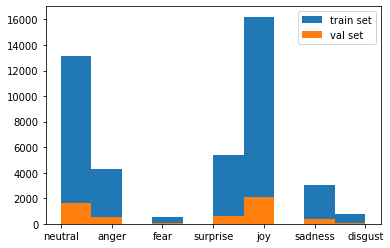

In [45]:
plt.hist(train["Emotion"], label="train set")
plt.hist(validation["Emotion"], label = "val set")
plt.legend()
plt.show()

### Preprocessing data

I define a routine `text_lite_preprocessing` in order to preprocess the `Text` column of the dataset

In [46]:
def text_lite_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x: str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're --> you are
  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
  df[column] = df[column].progress_apply(lambda x: re.sub(r'\d', "number", x))
  df[column] = df[column].progress_apply(lambda x: re.sub("_", "number", x))
  return (df)

In [47]:
train_clean_litemodel = text_lite_preprocessing(train, 'Text')
test_clean_litemodel = text_lite_preprocessing(test, 'Text')
val_clean_litemodel = text_lite_preprocessing(validation, 'Text')

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

Converting in lists the columns of the dataset (to ease the tokenization step)

In [48]:
x_train_litemodel = train_clean_litemodel['Text'].values.tolist()
y_train_litemodel = train_clean_litemodel['Emotion'].values.tolist()

x_test_litemodel= test_clean_litemodel['Text'].values.tolist()
y_test_litemodel= test_clean_litemodel['Emotion'].values.tolist()

x_val_litemodel= val_clean_litemodel['Text'].values.tolist()
y_val_litemodel =  val_clean_litemodel['Emotion'].values.tolist()

### Tokenization

I've used a Keras tokenizer to encode sentences into tokens: each word inside the sentence is translated into a list of numbers (each word corresponds to a number). A mapping words-to-numbers is built using the words used inside the training set

In [49]:
# creating tokenizer and fitting it on the training test
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(x_train_litemodel)

# printing a tokenization example
print("## Before tokenization: ")
print(x_train_litemodel[0])
print("## After tokenization: ")
print(tokenizer.texts_to_sequences([x_train_litemodel[0]])[0])

## Before tokenization: 
my favourite food is anything i did not have to cook myself
## After tokenization: 
[17, 1109, 491, 4, 199, 2, 59, 12, 19, 5, 3674, 348]


### Padding and Truncating Sequences
In order to have a standardized input length it is necessary to find a fixed dimension for the length of the sentence. Sentences exceeding `maxlen` will be cut, the ones not reaching it will instead be padded with zeros to reach `maxlen`.

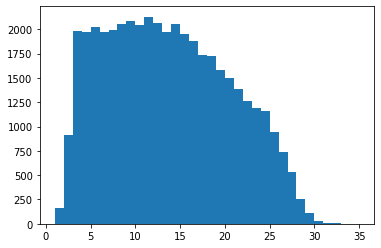

In [50]:
lengths = [len(t.split(' ')) for t in x_train_litemodel]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

We can easily see that most of the sentences has less than 27 words, so we set

In [51]:
maxlen = 27

In [52]:
def get_sequences(tokenizer, dataset):
  sequences = tokenizer.texts_to_sequences(dataset)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen= maxlen)
  return padded

Now I can pad the sentences for train, val and test set

In [53]:
padded_train_seq = get_sequences(tokenizer, x_train_litemodel)
padded_val_seq = get_sequences(tokenizer, x_val_litemodel)
padded_test_seq = get_sequences(tokenizer, x_test_litemodel)

In [54]:
padded_train_seq[0]

array([  17, 1109,  491,    4,  199,    2,   59,   12,   19,    5, 3674,
        348,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

### Preparing the labels

To use the labels in the neural network it is required to convert them in integer numbers (eachone corresponding to a neuron in the output layer)

In [55]:
classes = set(y_train_litemodel)
print(classes)

{'sadness', 'neutral', 'joy', 'disgust', 'anger', 'surprise', 'fear'}


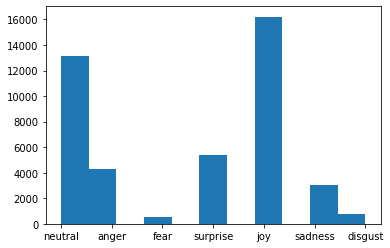

In [56]:
plt.hist(y_train_litemodel, bins =11)
plt.show()

This is the chosen mapping:

In [57]:
class_to_index = {'disgust':0, 'fear':1, 'neutral':2, 'anger':3, 'surprise':4, 'joy':5,'sadness':6}

In [58]:
names_to_ids = lambda labels_to_conv: np.array([class_to_index.get(x) for x in labels_to_conv])

y_train_litemodel = names_to_ids(y_train_litemodel)
y_val_litemodel = names_to_ids(y_val_litemodel)
y_test_litemodel =  names_to_ids(y_test_litemodel)

y_train_litemodel

array([2, 2, 3, ..., 3, 5, 5])

### Creating the model

In [59]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(4000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(7,activation='Softmax')
        
])

f1 = tfa.metrics.F1Score(num_classes=7,average='macro')
accuracy = 'accuracy'

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=10e-3),
    metrics = [accuracy,f1]
)

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 27, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 7)                 287       
                                                                 
Total params: 79,967
Trainable params: 79,967
Non-trainable params: 0
_________________________________________________________________


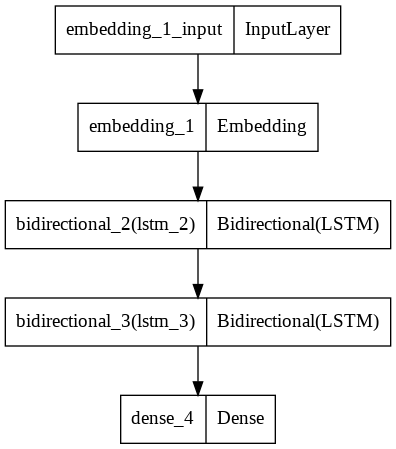

In [61]:
plot_model(model)

### Training

In [62]:
bilstm_history = model.fit(
    padded_train_seq, to_categorical(y_train_litemodel),
    validation_data=(padded_val_seq, to_categorical(y_val_litemodel)),
    epochs =8,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3, verbose=1, mode='max', restore_best_weights=True)],
    batch_size=70
)

Epoch 1/8
621/621 [==============================] - 13s 13ms/step - loss: 1.1821 - accuracy: 0.5707 - f1_score: 0.3607 - val_loss: 1.0303 - val_accuracy: 0.6185 - val_f1_score: 0.4400
Epoch 2/8
621/621 [==============================] - 6s 10ms/step - loss: 0.9827 - accuracy: 0.6419 - f1_score: 0.5145 - val_loss: 0.9972 - val_accuracy: 0.6321 - val_f1_score: 0.5380
Epoch 3/8
621/621 [==============================] - 6s 10ms/step - loss: 0.9028 - accuracy: 0.6725 - f1_score: 0.5805 - val_loss: 1.0090 - val_accuracy: 0.6327 - val_f1_score: 0.5287
Epoch 4/8
621/621 [==============================] - 6s 10ms/step - loss: 0.8431 - accuracy: 0.6935 - f1_score: 0.6121 - val_loss: 1.0239 - val_accuracy: 0.6303 - val_f1_score: 0.5333
Epoch 5/8
621/621 [==============================] - 6s 10ms/step - loss: 0.7856 - accuracy: 0.7142 - f1_score: 0.6375 - val_loss: 1.0547 - val_accuracy: 0.6233 - val_f1_score: 0.5251
Epoch 5: early stopping


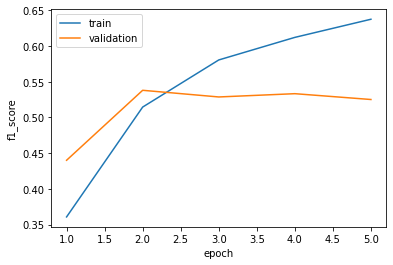

In [63]:
plot_history(bilstm_history,['f1_score','val_f1_score'])

In order to avoid saving the weights of an overfitted model i've used callbacks and saved the model at epoch 2 (**n.b.: the model with best f1 was found on another train than the one displayed in the notebook because i wanted to do more experiments and meanwhile i lost that output**)

### Testing

With the next command i load the weights through which i've obtained the best F1-macro-avg score (hosted in my GDrive)

In [64]:
bilstm_weights_url = get_file("bilstm.h5","https://github.com/eskinderit/SentimentAnalysisNNs/blob/main/weights/bilstm_weights.h5?raw=true") 
model.load_weights(bilstm_weights_url)

Running the model on the test set and storing the predicted labels:

In [65]:
y_pred_litemodel = model.predict(padded_test_seq)
# convertion of the guessed label in integer labels
y_pred_litemodel = np.argmax(y_pred_litemodel, axis = 1)

### Result

In [66]:
f1_macro = f1_score(y_test_litemodel,y_pred_litemodel, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

The final F1-score macro avg obtained on the test set is F1 = 0.5811467428131545


In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test_litemodel,y_pred_litemodel))

              precision    recall  f1-score   support

           0       0.58      0.49      0.53       116
           1       0.65      0.67      0.66        81
           2       0.57      0.68      0.62      1648
           3       0.48      0.40      0.44       572
           4       0.57      0.43      0.49       677
           5       0.77      0.76      0.77      1978
           6       0.58      0.55      0.57       355

    accuracy                           0.64      5427
   macro avg       0.60      0.57      0.58      5427
weighted avg       0.64      0.64      0.63      5427



## 2. Finetuning ALBERT

<div>
<img src="https://www.researchgate.net/publication/355434928/figure/fig1/AS:1080985038921730@1634738325417/The-architecture-of-the-ALBERT-model-in-our-task.ppm" width="500"/>
</div>

I've implemented many models from scratch (i didn't put them in this notebook just to keep it as clean as possible) and i've realized that
given that the dataset has many questionable labels (some of the samples could have been labeled in another category) and its relatively small size,
the only possible ways could have been to augment data (but in this case the unbalance is too strong, so i would have even risked to overfit) or to use
a pretrained model which was trained on a bigger dataset. I've decided to fine-tune **ALBERT (A Lite BERT), a lightweight version of the base model BERT (from Google)**.


ALBERT is a State-Of-The-Art Transformer-based model that achieved good performance scores in NLP benchamrks such as SQuAD1.1, SQuAD2.0, MNLI SST-2, RACE and many sentiment analysis datasets and tasks. ALBERT its way lighter then the original BERT model (it has just 11 M parameters instead of 110 M), so it is also a good compromise between performance and size of the model. 

**Some references**
*   [ALBERT: A Lite BERT for self-supervised
learning of language representations](https://arxiv.org/pdf/1909.11942.pdf)
*   [ALBERT-based sentiment analysis of movie review](https://ieeexplore.ieee.org/document/9513054)

*   [Google’s ALBERT Is a Leaner BERT; Achieves SOTA on 3 NLP Benchmarks](https://medium.com/syncedreview/googles-albert-is-a-leaner-bert-achieves-sota-on-3-nlp-benchmarks-f64466dd583)

*   [BERT-Based Sentiment Analysis: A Software
Engineering Perspective](https://arxiv.org/pdf/2106.02581v3.pdf)





### Importing the needed libraries

In [68]:
!pip install tensorflow-addons
!pip install sentencepiece
!pip install tensorflow_hub
!pip install transformers
!pip install text_hammer
from sklearn.metrics import classification_report, f1_score
from keras.utils.data_utils import get_file
from keras.utils.data_utils import get_file
import sentencepiece
from transformers import AlbertTokenizer, TFAlbertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import text_hammer as th
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#function to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

print('Using TensorFlow version', tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using TensorFlow version 2.8.2


### Importing data

In [69]:
test = pd.read_csv("https://raw.githubusercontent.com/eskinderit/SentimentAnalysisNNs/main/data/test_ekmann.csv")



train = pd.read_csv("https://raw.githubusercontent.com/eskinderit/SentimentAnalysisNNs/main/data/train_ekmann.csv")



validation = pd.read_csv("https://raw.githubusercontent.com/eskinderit/SentimentAnalysisNNs/main/data/val_ekmann.csv")

print("---------------------------------------------")
print("Dimension of test set: {}".format(test.shape))
print("Dimension of train set: {}".format(train.shape))
print("Dimension of validation set: {}".format(validation.shape))
print("---------------------------------------------")

print("Labels: ",np.unique(train["Emotion"]))

---------------------------------------------
Dimension of test set: (5427, 3)
Dimension of train set: (43410, 3)
Dimension of validation set: (5426, 3)
---------------------------------------------
Labels:  ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


### Visualizing the data

As we can see, the dataset is strongly umbalanced and there are just few samples for "fear" and "disgust" 

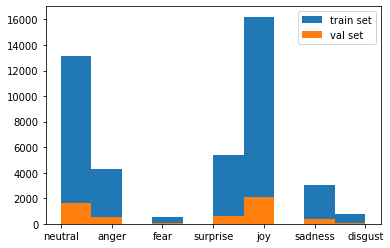

In [70]:
plt.hist(train["Emotion"], label="train set")
plt.hist(validation["Emotion"], label = "val set")
plt.legend()
plt.show()

### Preprocessing data

I define a routine `text_albert_preprocessing` in order to preprocess the `Text` column of the dataset

In [71]:
def text_albert_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x: str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're --> you are
  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
  return (df)

In [72]:
data_train_albert = text_albert_preprocessing(train, 'Text')
data_test_albert = text_albert_preprocessing(test, 'Text')
data_val_albert = text_albert_preprocessing(validation, 'Text')

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

### Tokenization, padding and truncating sequences

computing the maximum length (in words) of the sentences contained in the train set 

In [73]:
# adding a column to count the number of words in each sentence
data_train_albert['num_words'] = data_train_albert.Text.apply(lambda x:len(x.split()))
data_test_albert['num_words'] = data_test_albert.Text.apply(lambda x:len(x.split()))
data_val_albert['num_words'] = data_val_albert.Text.apply(lambda x:len(x.split()))

In [74]:
n_words_train = data_train_albert.num_words.max()
n_words_val = data_val_albert.num_words.max()
n_words_test = data_test_albert.num_words.max()

print("Max word in train set: {}".format(n_words_train))
print("Max word in validation set: {}".format(n_words_val))
print("Max word in tets set: {}".format(n_words_test))

max_words = max([n_words_train, n_words_val, n_words_test])

print("The maximum number of words is {}".format(max_words)) 

Max word in train set: 35
Max word in validation set: 31
Max word in tets set: 32
The maximum number of words is 35


In [75]:
maxlen = 70

Here I import the pre-trained model. In order to make it work it is necessary to use its own custom tokenizer

In [76]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = TFAlbertModel.from_pretrained("albert-base-v2")

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [77]:
# printing a tokenization example
print("## Before tokenization: ")
print(data_train_albert["Text"][0])
print("## After tokenization: ")
print(tokenizer(data_train_albert["Text"][0]))

## Before tokenization: 
my favourite food is anything i did not have to cook myself
## After tokenization: 
{'input_ids': [2, 51, 7740, 950, 25, 602, 31, 144, 52, 57, 20, 3800, 992, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Now I can convert, cut and pad the sentences for train, val and test set

In [78]:
x_train_albert = tokenizer(
    text = data_train_albert.Text.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_albert = tokenizer(
    text = data_val_albert.Text.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test_albert = tokenizer(
    text = data_test_albert.Text.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = "max_length",
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

### Preparing the labels

To use the labels in the neural network it is required to convert them in integer numbers (eachone corresponding to a neuron in the output layer)

In [79]:
encoded_dict={'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5,'surprise':6}

print(np.unique(data_train_albert.Emotion))

def convert(sentiment):
    return encoded_dict.get(sentiment)

y_train_albert = data_train_albert["Emotion"].map(encoded_dict)

y_test_albert = data_test_albert["Emotion"].map(encoded_dict)

y_val_albert = data_val_albert["Emotion"].map(encoded_dict)

data_train_albert.head()

['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


,Text,Emotion,Id,num_words
0,my favourite food is anything i did not have t...,neutral,eebbqej,12
1,now if he does off himself everyone will think...,neutral,ed00q6i,20
2,why the fuck is bayless isoing,anger,eezlygj,6
3,to make her feel threatened,fear,ed7ypvh,5
4,dirty southern wankers,anger,ed0bdzj,3


### Creating the model

In [80]:
# input
input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
# pretrained 
embeddings = albert([input_ids, input_mask])[0] #(0 is the last hidden layer, 1 means pooler output)
# last layers and output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)
y = Dense(7, activation = 'Softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs = y)
model.layers[2].trainable = True

In [81]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_albert_model_1 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_ids[0][0]',              
 el)                            thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 70,                                               
                                 768),                                                      

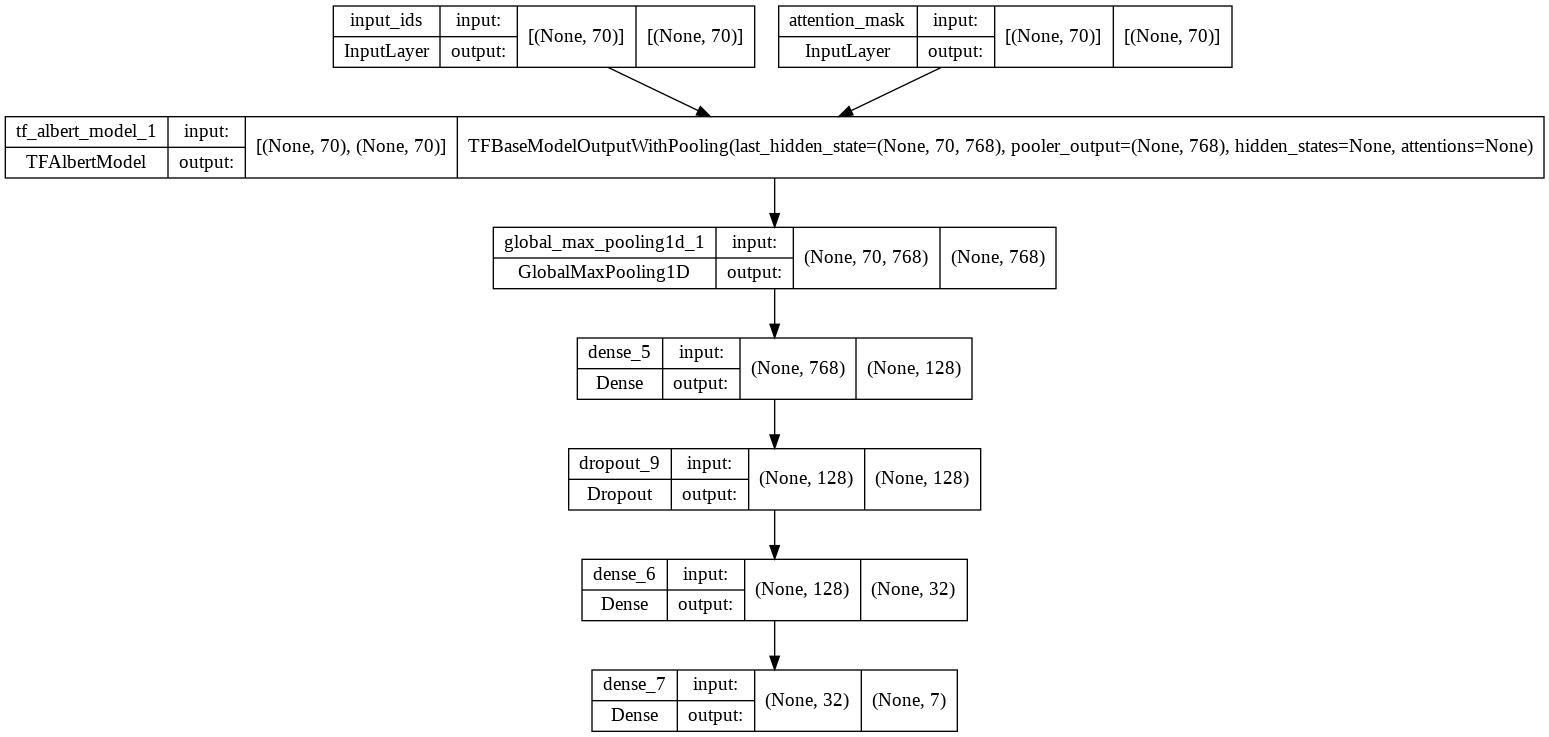

In [82]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [83]:
optimizer=Adam(
    learning_rate = 3e-05, # this learning rate is for bert model, taken from hugging face site
    epsilon = 1e-08,
    decay = 0.01,
    clipnorm = 1.0)

# set loss and metrics 
loss = 'categorical_crossentropy'#CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy(name='balanced_accuracy',dtype='float32')
f1 = tfa.metrics.F1Score(num_classes=7,average='macro')

# compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric,f1]
)

### Training

In [84]:
albert_history = model.fit(
    x = {'input_ids': x_train_albert['input_ids'],'attention_mask':x_train_albert['attention_mask']},
    y = to_categorical(y_train_albert),
    validation_data = ({'input_ids':x_val_albert['input_ids'],'attention_mask':x_val_albert['attention_mask']}, to_categorical(y_val_albert)),
    epochs=7, 
    batch_size=80,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=2, verbose=1, mode='max', restore_best_weights=True)]
)

Epoch 1/7
543/543 [==============================] - 369s 657ms/step - loss: 1.0992 - balanced_accuracy: 0.6047 - f1_score: 0.3977 - val_loss: 0.9124 - val_balanced_accuracy: 0.6672 - val_f1_score: 0.5385
Epoch 2/7
543/543 [==============================] - 353s 651ms/step - loss: 0.9041 - balanced_accuracy: 0.6734 - f1_score: 0.5469 - val_loss: 0.8867 - val_balanced_accuracy: 0.6756 - val_f1_score: 0.5792
Epoch 3/7
543/543 [==============================] - 353s 651ms/step - loss: 0.8533 - balanced_accuracy: 0.6894 - f1_score: 0.5913 - val_loss: 0.8868 - val_balanced_accuracy: 0.6782 - val_f1_score: 0.5922
Epoch 4/7
543/543 [==============================] - 354s 651ms/step - loss: 0.8230 - balanced_accuracy: 0.7021 - f1_score: 0.6159 - val_loss: 0.8780 - val_balanced_accuracy: 0.6802 - val_f1_score: 0.5965
Epoch 5/7
543/543 [==============================] - 353s 651ms/step - loss: 0.8032 - balanced_accuracy: 0.7116 - f1_score: 0.6262 - val_loss: 0.8777 - val_balanced_accuracy: 0.675

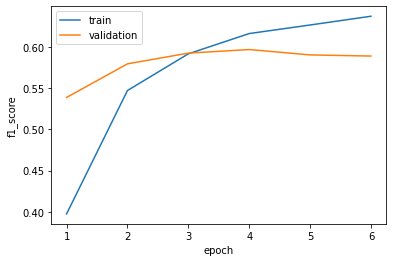

In [85]:
plot_history(albert_history,['f1_score','val_f1_score'])

In order to avoid saving the weights of an overfitted model i've used callbacks and saved the model at epoch 4 (**n.b.: the model with best f1 was found on another train than the one displayed in the notebook because i wanted to do more experiments and meanwhile i lost that output**)

### Testing

With the next command i load the weights through which i've obtained the best F1-macro-avg score (hosted in my GDrive)

In [86]:
albert_weights_url = get_file("albert.h5","https://github.com/eskinderit/SentimentAnalysisNNs/blob/main/weights/albert_weights.h5?raw=true") 
model.load_weights(albert_weights_url)

47210496/47194896 [==============================] - 0s 0us/step


Running the model on the test set and storing the predicted labels:

In [87]:
y_pred_albert = model.predict({'input_ids':x_test_albert['input_ids'],'attention_mask':x_test_albert['attention_mask']})
# convertion of the guessed label in integer labels
y_pred_albert = np.argmax(y_pred_albert, axis = 1)

### Result

In [88]:
f1_macro = f1_score(y_test_albert,y_pred_albert, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

The final F1-score macro avg obtained on the test set is F1 = 0.6076302313754983


In [89]:
print(classification_report(y_test_albert,y_pred_albert))

              precision    recall  f1-score   support

           0       0.55      0.44      0.49       572
           1       0.56      0.43      0.49       116
           2       0.70      0.64      0.67        81
           3       0.81      0.80      0.80      1978
           4       0.61      0.71      0.66      1648
           5       0.61      0.53      0.57       355
           6       0.60      0.55      0.57       677

    accuracy                           0.68      5427
   macro avg       0.64      0.59      0.61      5427
weighted avg       0.68      0.68      0.67      5427



# Results and conclusions

I presented these as the best models i've implemented. Bi-LSTM achieves a good performance and is really lightweight (just 80k parameters) but ALBERT is a SOTA model and has given the best score even mantaining a "normal-medium" size. Therefore the model achieving the best F1 is ALBERT.

Model    | n. of params | F1-macro-avg | comment 
---------|--------------|--------------|------------
Bi-LSTM  |     80K     |     0.58     | lightweight
ALBERT   |     11M      |     0.61     | best - SOTA level